In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

## Setting up the solution 1D

u_x = f(x)

In [2]:
def u(x):
    func = 2*x**3 - 3*x**2 + x
    return func
    
def f_(x):
    func = 12*x - 6
    return func

In [3]:
def u(x):
    return torch.exp(-x) - torch.sin(x)
def f(x):
    return torch.exp(-x) + torch.sin(x)

In [4]:
x = torch.rand(100,1, requires_grad=True)
u_exact = u(x)
x_b = torch.tensor([[0.0], [1.0]], requires_grad=True)
u_b = u(x_b)
f = f_(x)

In [5]:
x_val = torch.rand(100,1, requires_grad=True)
u_val = u(x_val)

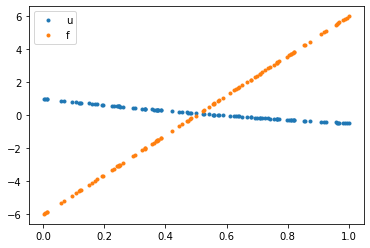

In [6]:
plt.plot(x.detach(), u_exact.detach(), '.', label='u')
plt.plot(x.detach(), f.detach(), '.', label='f')
plt.legend()

In [7]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
                nn.Sigmoid(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, u_b):
        u_b_hat = self.forward(x_b)
        loss = self.loss_func(u_b, u_b_hat)
        return loss

    def loss_PDE(self, x, f):
        u_hat = self.forward(x)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        loss = self.loss_func(f, u_xx_hat)
        return loss
    
    def loss(self, x, f, x_b, u_b):
        loss = self.loss_BC(x_b, u_b) + self.loss_PDE(x, f)
        return loss
    
    def step(self, x, f, x_b, u_b ):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, f, x_b, u_b)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_BC(x_b, u_b), self.loss_PDE(x, f)

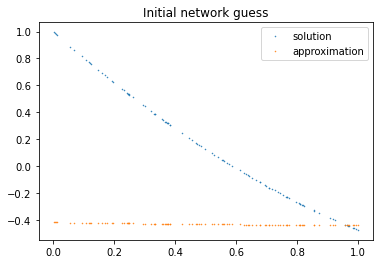

In [8]:
loss = []
epochs = 10000
N_in = 1
N_out = 1
net = Net(N_in, N_out, N_hid=10)
plt.plot(x.detach(), u_exact.detach(), '.', label='solution', markersize=1)
plt.plot(x.detach(), net(x).detach(), '.', label='approximation', markersize=1)
plt.legend()
plt.title('Initial network guess')

for e in range(epochs):
    loss.append(net.step(x, f, x_b, u_b))

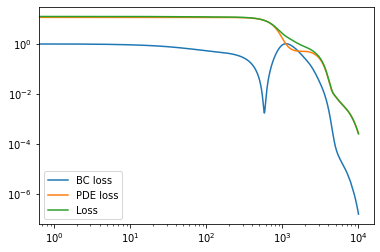

In [11]:
plt.plot([bc.detach() for bc, pde in loss], label='BC loss')
plt.plot([pde.detach() for bc, pde in loss], label='PDE loss')
plt.loglog([pde.detach() + bc.detach() for bc, pde in loss], label='Loss')


plt.legend()

Text(0.5, 1.0, 'Trained network estimate')

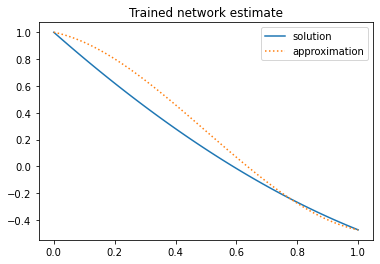

In [16]:
x_val = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1,1)
plt.plot(x_val.detach(), u(x_val).detach(),  label='solution')
plt.plot(x_val.detach(), net(x_val).detach(), ':', label='approximation')
plt.legend()
plt.title('Trained network estimate')

Text(0.5, 1.0, 'u_xx')

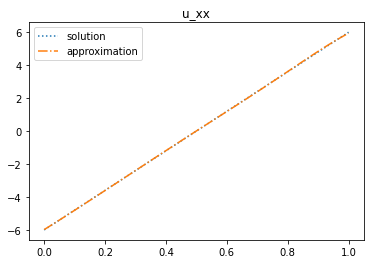

In [23]:
u_x_hat = torch.autograd.grad(net(x_val), x_val, torch.ones(x_val.shape), create_graph=True)[0]
u_xx_hat = torch.autograd.grad(u_x_hat, x_val, torch.ones(x_val.shape))[0]
plt.plot(x_val.detach(), f_(x_val).detach(), ':', label='solution')
plt.plot(x_val.detach(), u_xx_hat.detach(),'-.', label='approximation')
plt.legend()
plt.title('u_xx')

## Setting it all up in 2D

### Training and validation data + visualization

In [26]:
k1 = 2
k2 = 3
def u(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    func = torch.sin(k1*x1 + k2*x2)
    return func
    
def f_(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    func = -(k1**2 + k2**2)*torch.sin(k1*x1 + k2*x2)
    return func

In [27]:
n_train = 100
n_val = 10
n_b = 10

In [28]:
x_train = torch.rand(n_train, 2, requires_grad=True)
x_val = torch.rand(n_val, 2, requires_grad=True)
u_train = u(x_train).reshape(-1, 1)
u_val = u(x_val).reshape(-1, 1)
x_b = torch.cat((torch.zeros((n_b,1)), torch.rand((n_b,1))), dim=1)
x_b = torch.cat((x_b, torch.cat((torch.ones((n_b,1)), torch.rand((n_b,1))), dim=1)), dim=0)
x_b = torch.cat((x_b, torch.cat((torch.rand((n_b,1)), torch.zeros((n_b,1))), dim=1)), dim=0)
x_b = torch.cat((x_b, torch.cat((torch.rand((n_b,1)), torch.ones((n_b,1))), dim=1)), dim=0)
u_b = u(x_b)
f = f_(x_train)

### Derivatives

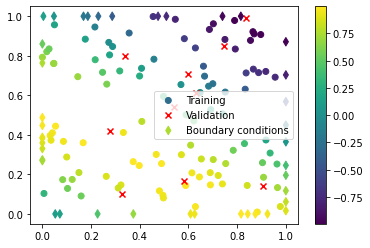

In [29]:
plt.scatter(x_train[:,0].detach(), x_train[:,1].detach(), c=u_train.detach(), label='Training')
plt.colorbar
plt.scatter(x_val[:,0].detach(), x_val[:,1].detach(), marker='x', c='red', label='Validation')
plt.scatter(x_b[:,0], x_b[:,1], c=u_b, marker='d' ,label='Boundary conditions')
plt.colorbar()
plt.legend()

In [30]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
#                nn.Sigmoid(),
#                nn.Linear(in_features=N_hid,
#                         out_features=N_hid,
#                         bias=True),
                nn.Tanh(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, u_b):
        u_b_hat = self.forward(x_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss

    def loss_PDE(self, x, f):
        u_hat = self.forward(x)
        # First derivative. [du/dx1, du/dx2]
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(u_hat.shape), create_graph=True)[0]
        
        # Second derivatives. [du/dx1x1, du/dx1x2]
        u_x1_x_hat = torch.autograd.grad(u_x_hat[:,:1], x, torch.ones(u_x_hat[:,:1].shape), create_graph=True)[0]
        
        # Second derivatives. [du/dx2x1, du/dx2x2]
        u_x2_x_hat = torch.autograd.grad(u_x_hat[:,-1:], x, torch.ones(u_x_hat[:,-1:].shape), create_graph=True)[0]
        
        u_xx_hat = u_x1_x_hat[:, :1] + u_x2_x_hat[:, -1:]
        loss = self.loss_func(f, u_xx_hat.reshape(f.shape))
        
        return loss
    
    def loss(self, x, f, x_b, u_b):
        loss = self.loss_BC(x_b, u_b) + self.loss_PDE(x, f)
        return loss
    
    def step(self, x, f, x_b, u_b ):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, f, x_b, u_b)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss

In [31]:
loss = []
epochs = 20000
N_in = 2
N_out = 1
N_hid = 100
net = Net(N_in, N_out, N_hid)
u_hat = net(x_train)
for e in range(epochs):
    loss.append(net.step(x_train, f, x_b, u_b).detach())
    if e%100 == 0:
        print("PDE + BC loss = {:.2f}. Validation loss = {:.2f}".format(loss[-1], ((net(x_val) - u_val)**2).detach().sum()/len(u_val)))


PDE + BC loss = 86.24. Validation loss = 0.49
PDE + BC loss = 68.02. Validation loss = 0.92
PDE + BC loss = 36.29. Validation loss = 1.57
PDE + BC loss = 13.14. Validation loss = 2.47
PDE + BC loss = 5.18. Validation loss = 1.34
PDE + BC loss = 2.92. Validation loss = 0.53
PDE + BC loss = 1.94. Validation loss = 0.29
PDE + BC loss = 1.30. Validation loss = 0.22
PDE + BC loss = 0.86. Validation loss = 0.18
PDE + BC loss = 0.57. Validation loss = 0.15
PDE + BC loss = 0.38. Validation loss = 0.13
PDE + BC loss = 0.27. Validation loss = 0.11
PDE + BC loss = 0.20. Validation loss = 0.09
PDE + BC loss = 0.15. Validation loss = 0.08
PDE + BC loss = 0.12. Validation loss = 0.07
PDE + BC loss = 0.10. Validation loss = 0.06
PDE + BC loss = 0.09. Validation loss = 0.05
PDE + BC loss = 0.08. Validation loss = 0.04
PDE + BC loss = 0.07. Validation loss = 0.04
PDE + BC loss = 0.06. Validation loss = 0.03
PDE + BC loss = 0.05. Validation loss = 0.03
PDE + BC loss = 0.05. Validation loss = 0.03
PDE + 

PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00
PDE + BC loss = 0.00. Validation loss = 0.00


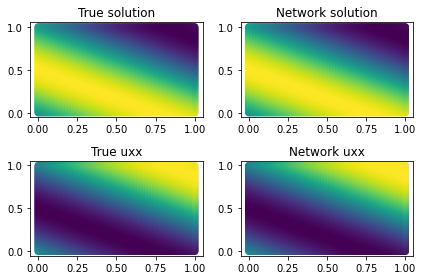

In [32]:
## Evaluate network
xi, yi = torch.meshgrid(torch.linspace(0,1,101, requires_grad=True), torch.linspace(0,1,101, requires_grad=True))

x_grid = torch.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))
minmax = u(x_grid).detach()
vmin = minmax.min()
vmax = minmax.max()
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(x_grid[:, 0].detach(), x_grid[:, 1].detach(), c=u(x_grid).detach(), vmin=vmin, vmax=vmax)
ax[0,0].set_title('True solution')
ax[0,1].scatter(x_grid[:, 0].detach(), x_grid[:, 1].detach(), c=net(x_grid).detach(), vmin=vmin, vmax=vmax)
ax[0,1].set_title('Network solution')

minmax = f_(x_grid).detach()
vmin = minmax.min()
vmax = minmax.max()
ax[1,0].scatter(x_grid[:, 0].detach(), x_grid[:, 1].detach(), c=f_(x_grid).detach(), vmin=vmin, vmax=vmax)
ax[1,0].set_title('True uxx')
ax[1,1].set_title('Network uxx')

u_hat = net(x_grid)
# First derivative. [du/dx1, du/dx2]
u_x_hat = torch.autograd.grad(u_hat, x_grid, torch.ones(u_hat.shape), create_graph=True)[0]
# Second derivatives. [du/dx1x1, du/dx1x2]
u_x1_x_hat = torch.autograd.grad(u_x_hat[:,:1], x_grid, torch.ones(u_hat.shape), create_graph=True)[0]
# Second derivatives. [du/dx2x1, du/dx2x2]
u_x2_x_hat = torch.autograd.grad(u_x_hat[:,-1:], x_grid, torch.ones(u_hat.shape), create_graph=True)[0]
u_xx_hat = u_x1_x_hat[:, :1] + u_x2_x_hat[:, -1:]
ax[1,1].scatter(x_grid[:,0].detach(), x_grid[:,1].detach(), c=u_xx_hat.detach(), vmin=vmin, vmax=vmax)
fig.tight_layout()

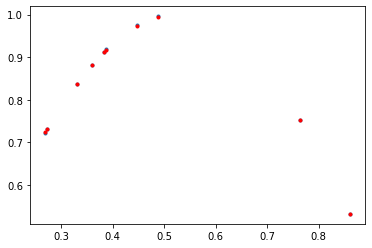

In [33]:
plt.plot(x_b[:10, 1].detach(), net(x_b[:10, :]).detach(), '.')
plt.plot(x_b[:10, 1].detach(), u(x_b[:10, :]).detach(), '.', color='red')
plt.title('Boundary conditions')

Text(0.5, 1.0, 'Boundary conditions')

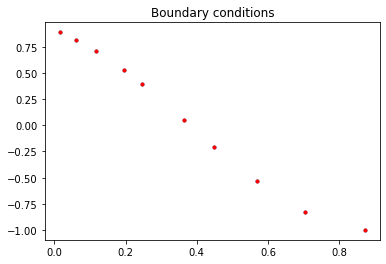

In [35]:
plt.plot(x_b[10:20, 1].detach(), net(x_b[10:20, :]).detach(), '.')
plt.plot(x_b[10:20, 1].detach(), u(x_b[10:20, :]).detach(), '.', color='red')
plt.title('Boundary conditions')